In [1]:

import puma
import h5py
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D
from ftag import Cuts

data = h5py.File('/eos/home-a/anmilici/ntupla.h5','r')

In [2]:



flavour_cuts = Cuts.from_list([("PartonTruthLabelID", "==", 5),("HadronConeExclTruthLabelID","==",5)])
#in this way i select jets tagged with bjets at parton level and which contain at least a bhadron (shall i use HadronConeExtendedExclTruthLabelID ?)

#get 50000 bjets

idx,bjets=flavour_cuts(data["jets"][0:50000])
tracks=data["tracks"][idx]

print("nbjets=",len(bjets))
print("ntracks=",len(tracks))

nbjets= 18329
ntracks= 18329


In [3]:
#neutral bhadrons from all the possible values of HadronConeExclTruthLabelPdgId

neutral_bhadrons_list=[511,531,551,553,555,5122,5232,-511,-531,-551,-553,-555,-5122,-5232]

neutral_bhadrons_cut=Cuts.from_list([("HadronConeExclTruthLabelPdgId","==",x) for x in neutral_bhadrons_list])
neutral_bjets=neutral_bhadrons_cut(bjets).values

#charged bhadrons are what it remains

charged_bhadrons_cut=Cuts.from_list([("HadronConeExclTruthLabelPdgId","!=",x) for x in neutral_bhadrons_list])
index,charged_bjets=charged_bhadrons_cut(bjets)
charged_tracks=tracks[index]

positive_bhadrons_cut=Cuts.from_list([("HadronConeExclTruthLabelPdgId",">",0)])
pos_bjets=positive_bhadrons_cut(charged_bjets).values

negative_bhadrons_cut=Cuts.from_list([("HadronConeExclTruthLabelPdgId","<",0)])
neg_bjets=negative_bhadrons_cut(charged_bjets).values

#total number of jet with a charged B hadron we are looking at

ncharged=len(charged_bjets)

npos=len(pos_bjets)
nneg=len(neg_bjets)

print("number of charged bjet=",ncharged)
print("truth positive=",npos)
print("truth negative=",nneg)

number of charged bjet= 8098
truth positive= 4067
truth negative= 4031


In [4]:
def charge_algorithm(index,tracks,
                     mode:str):
  string=' '

  if mode=="GN2":
    string='GN2v01_aux_TrackOrigin'
  elif mode=='truth':
    string='ftagTruthOriginLabel'

  #cutting on all the tracks that has not ftagTruthOriginLabel == 3(fromB) or 4(fromBC)

  truth_fromB_BC_cuts=Cuts.from_list([(string,"!=",0),
                                      (string,"!=",1),
                                      (string,"!=",2),
                                      (string,"!=",5),
                                      (string,"!=",6),
                                      (string,"!=",7),
                                      ("valid","==",True)])

  secondaries=truth_fromB_BC_cuts(tracks).values
  charge=np.sign(secondaries["qOverP"]).sum()
  return charge

  '''
  NO NEED, SKIP THIS PART
  if mode=='truth':

    type_cuts_2356=Cuts.from_list([("ftagTruthTypeLabel","!=",0),
                                   ("ftagTruthTypeLabel","!=",1),
                                   ("ftagTruthTypeLabel","!=",4),
                                   ("ftagTruthTypeLabel","!=",-4),
                                   ("ftagTruthTypeLabel","!=",7),
                                   ("ftagTruthTypeLabel","!=",-7)])

    good_tracks=type_cuts_2356(secondaries).values

    TruthTypes=good_tracks["ftagTruthTypeLabel"]
    type_dict={2:2,-2:-2,  3:3,-3:-3,5:-5,-5:5,6:-6,-6:6}
    map= np.vectorize(lambda x: type_dict[x])

    if TruthTypes.size>0:
      charge=np.sign(map(TruthTypes)).sum()
      return charge
    else:
      #DEBUG
      print("no good tracks")
      print(TruthTypes)
      print(secondaries['ftagTruthTypeLabel'])
      print(secondaries['qOverP'])
      print(index)
      print(charged_bjets[index]["HadronConeExclTruthLabelPdgId"])
      n=charged_bjets[index]["n_tracks"]
      print('ntracks=',n)
      print('ftagTruthTypeLabeL==',charged_tracks[index][0:n]["ftagTruthTypeLabel"])
      print('ftagTruthOriginLabel==',charged_tracks[index][0:n]["ftagTruthOriginLabel"])
      print('nevent',charged_bjets[index]["eventNumber"])
      '''

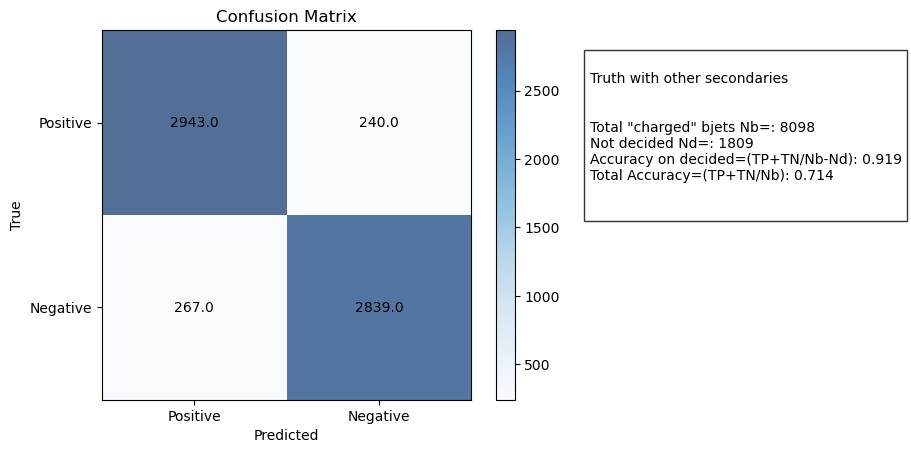

In [5]:
confusion_matrix=np.zeros((2,2))
debug=False
not_decided=0
residuals=[]

for i,jet in enumerate(charged_bjets):

  charge=charge_algorithm(i,charged_tracks[i],'truth')

  # taking the residuals absolute value
  residuals.append(np.abs(np.sign(jet["HadronConeExclTruthLabelPdgId"])-np.sign(charge)))

  if jet["HadronConeExclTruthLabelPdgId"]>0:
    if charge>0:
      confusion_matrix[0,0]+=1
    elif charge<0:
      confusion_matrix[0,1]+=1

  elif jet["HadronConeExclTruthLabelPdgId"]<0:
    if charge>0:
      confusion_matrix[1,0]+=1
    elif charge<0:
      confusion_matrix[1,1]+=1

  #this is the case where the sum of the tracks is zero, we count these events in not_decided
  if charge==0:
    not_decided+=1

  if debug==True:
    print("bhadron=",jet["HadronConeExclTruthLabelPdgId"])
    print("charge SUM=",charge)
    print("\n")
    if i>200:
        break

# just plotting the confusion matrix

plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest',alpha=0.7)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.xticks([0, 1], ['Positive', 'Negative'])
plt.yticks([0, 1], ['Positive', 'Negative'])
for i in range(confusion_matrix.shape[0]):  # righe
    for j in range(confusion_matrix.shape[1]):  # colonne
        plt.text(j, i, confusion_matrix[i, j],
                 ha='center', va='center', color='black')


text_box = f"""
Truth with other secondaries
\n
Total "charged" bjets Nb=: {len(charged_bjets)}
Not decided Nd=: {not_decided}
Accuracy on decided=(TP+TN/Nb-Nd): {((confusion_matrix[0,0]+confusion_matrix[1,1])/(len(charged_bjets)-not_decided)).round(3)}
Total Accuracy=(TP+TN/Nb): {((confusion_matrix[0, 0] + confusion_matrix[1, 1]) / len(charged_bjets)).round(3)}

"""
text=plt.gcf().text(0.93, 0.5, text_box, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))


plt.savefig('TRUTH_with_OtherSec.png', dpi=300, bbox_inches='tight')









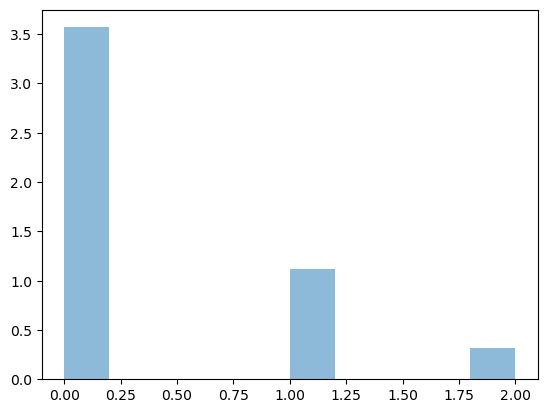

In [6]:
hist=plt.hist(residuals,alpha=0.5,density=True)
plt.show()


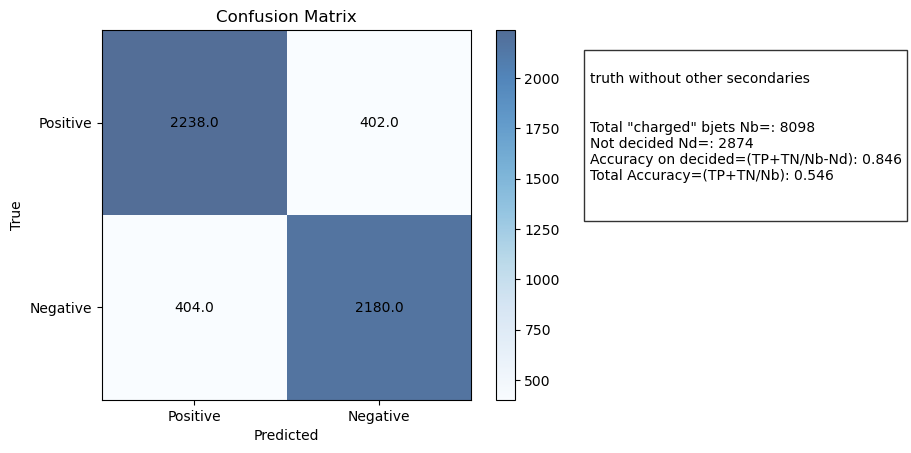

In [7]:
confusion_matrix=np.zeros((2,2))
debug=False
not_decided=0
residuals=[]

for i,jet in enumerate(charged_bjets):

  charge=charge_algorithm(i,charged_tracks[i],'GN2')
  residuals.append(np.abs(np.sign(jet["HadronConeExclTruthLabelPdgId"])-np.sign(charge)))



  if jet["HadronConeExclTruthLabelPdgId"]>0:
    if charge>0:
      confusion_matrix[0,0]+=1
    elif charge<0:
      confusion_matrix[0,1]+=1

  elif jet["HadronConeExclTruthLabelPdgId"]<0:
    if charge>0:
      confusion_matrix[1,0]+=1
    elif charge<0:
      confusion_matrix[1,1]+=1

  if charge==0:
    not_decided+=1

  if debug==True:
    print("bhadron=",jet["HadronConeExclTruthLabelPdgId"])
    if i>50:
        break

plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest',alpha=0.7)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.xticks([0, 1], ['Positive', 'Negative'])
plt.yticks([0, 1], ['Positive', 'Negative'])
for i in range(confusion_matrix.shape[0]):  # righe
    for j in range(confusion_matrix.shape[1]):  # colonne
        plt.text(j, i, confusion_matrix[i, j],
                 ha='center', va='center', color='black')


text_box = f"""
truth without other secondaries
\n
Total "charged" bjets Nb=: {len(charged_bjets)}
Not decided Nd=: {not_decided}
Accuracy on decided=(TP+TN/Nb-Nd): {((confusion_matrix[0,0]+confusion_matrix[1,1])/(len(charged_bjets)-not_decided)).round(3)}
Total Accuracy=(TP+TN/Nb): {((confusion_matrix[0, 0] + confusion_matrix[1, 1]) / len(charged_bjets)).round(3)}

"""
text=plt.gcf().text(0.93, 0.5, text_box, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))


plt.savefig('GN2_with_OtherSec.png', dpi=300, bbox_inches='tight')









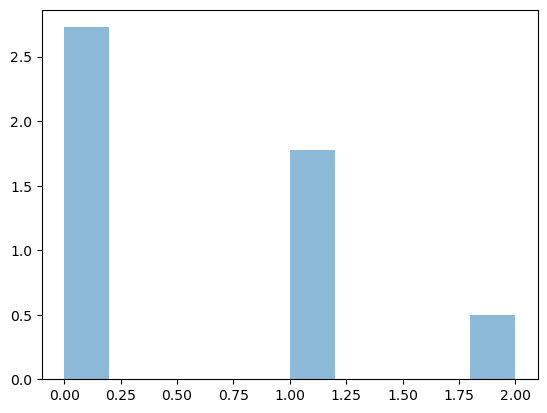

In [8]:
hist=plt.hist(residuals,alpha=0.5,density=True)
plt.show()
